# Text Classification with Bag of Words - Natural Language Processing

![](https://i.imgur.com/hlEQ5X8.png)

> _"Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language, in particular how to program computers to process and analyze large amounts of natural language data."_ - Wikipedia

> _**Bag of Words**: The bag-of-words (BOW) model is a representation that turns arbitrary text into fixed-length vectors by counting how many times each word appears._
 
Outline:

1. Download and explore a real-world dataset
2. Apply text preprocessing techniques
3. Implement the bag of words model
4. Train ML models for text classification
5. Make predictions and submit to Kaggle


Dataset: https://www.kaggle.com/c/quora-insincere-questions-classification


In [1]:
%matplotlib inline

import os
import re

import tensorflow as tf

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split as split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

In [2]:
train_csv = '../data/Quora/train.csv'

In [3]:
raw_data = pd.read_csv(train_csv)
raw_data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


## Work on Sample dataset:

In [5]:
sample_data =  raw_data.sample(frac=.2)
sample_data.pop('qid')
sample_data.head()

,question_text,target
1256900,Is it necessary for Blacks who come from new Y...,1
581819,What are the things which I can learn during m...,0
276873,"How do you make a question so famous on Quora,...",0
617967,Is the Miss BumBum competition really very pop...,0
1025385,Do I need to disclose my asset details during ...,0


In [6]:
sample_data.shape

(261224, 2)

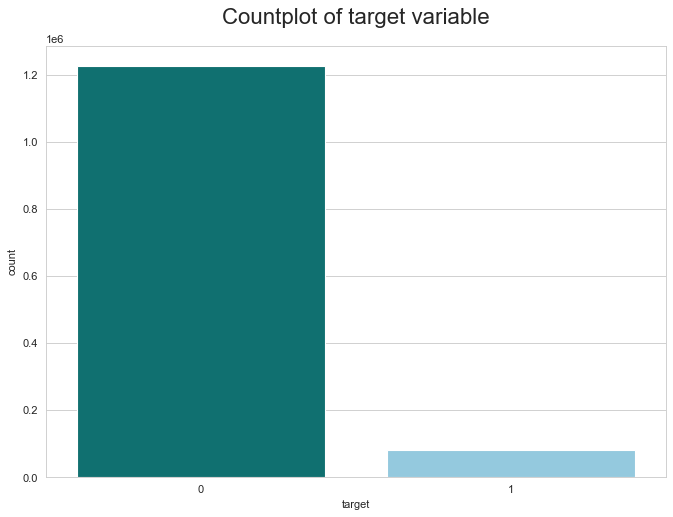

In [7]:
# - countplot on raw data(not sampled data)
plt.figure(figsize=(10, 7), dpi=80)
plt.title("Countplot of target variable", size=20, pad=20)
sns.countplot(data = raw_data, x = 'target', palette=['teal', 'skyblue'])
plt.show()

In [8]:
sample_data.question_text.values[:5]

array(['Is it necessary for Blacks who come from new York to choose Guangzhou as their second home?',
       'What are the things which I can learn during my 2 two months vacations being in second year of electronics and communication to enhance my resume?',
       'How do you make a question so famous on Quora, so that it appears on the Quora newsletter?',
       'Is the Miss BumBum competition really very popular in Brazil?',
       'Do I need to disclose my asset details during IPS training?'],
      dtype=object)

## Create Dataset for tensorflow Tokenization:

In [10]:
def custom_processing(input_sentences) -> list:
    table = []
    clean = re.compile(r'<.*?>')
    for sent in input_sentences:
        txt = re.sub(clean, '', sent)
        t = re.sub(r'[^\w\s]', '', txt.lower())
        table.append(t)
    return table

In [12]:
all_questions = np.array(sample_data.question_text.values)
all_labels = np.array(sample_data.target.values)

In [13]:
clean_questions = custom_processing(all_questions)
clean_questions[:5]

['is it necessary for blacks who come from new york to choose guangzhou as their second home',
 'what are the things which i can learn during my 2 two months vacations being in second year of electronics and communication to enhance my resume',
 'how do you make a question so famous on quora so that it appears on the quora newsletter',
 'is the miss bumbum competition really very popular in brazil',
 'do i need to disclose my asset details during ips training']

In [16]:
train_inp, val_inp, train_target, val_target = split(
    clean_questions, all_labels, test_size=.25, random_state=42)

print(
    f"training size: {len(train_inp)}", 
    f"validation size: {len(val_inp)}", 
    sep="\n"
)

training size: 195918
validation size: 65306


## Generate Tokens and Padded Sequencess:

In [18]:
# - params
vocab_size: int = 10_000
max_length: int = 120
embedding_dim: int = 16
truncation_type: str = 'post'
oov_token = '<OOV>'

In [21]:
# Initialize tensorflow tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_token)

# fit and generate word index dictionary on training set
tokenizer.fit_on_texts(train_inp)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_inp)
training_paded = tf.keras.utils.pad_sequences(training_sequences, maxlen=max_length, truncating=truncation_type)

# validation dataset
val_sequences = tokenizer.texts_to_sequences(val_inp)
val_paded = tf.keras.utils.pad_sequences(val_sequences, maxlen=max_length, truncating=truncation_type)

## Build and Compile model :

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(training_paded, train_target, validation_data=(val_paded, val_target), epochs=10)

Epoch 1/10
6123/6123 [==============================] - 26s 4ms/step - loss: 0.1748 - accuracy: 0.9430 - val_loss: 0.1367 - val_accuracy: 0.9483
Epoch 2/10
6123/6123 [==============================] - 25s 4ms/step - loss: 0.1284 - accuracy: 0.9503 - val_loss: 0.1291 - val_accuracy: 0.9501
Epoch 3/10
6123/6123 [==============================] - 24s 4ms/step - loss: 0.1200 - accuracy: 0.9526 - val_loss: 0.1309 - val_accuracy: 0.9506
Epoch 4/10
6123/6123 [==============================] - 24s 4ms/step - loss: 0.1157 - accuracy: 0.9538 - val_loss: 0.1336 - val_accuracy: 0.9503
Epoch 5/10
6123/6123 [==============================] - 25s 4ms/step - loss: 0.1131 - accuracy: 0.9551 - val_loss: 0.1304 - val_accuracy: 0.9509
Epoch 6/10
6123/6123 [==============================] - 25s 4ms/step - loss: 0.1112 - accuracy: 0.9553 - val_loss: 0.1326 - val_accuracy: 0.9501
Epoch 7/10
6123/6123 [==============================] - 24s 4ms/step - loss: 0.1099 - accuracy: 0.9559 - val_loss: 0.1345 - val_ac

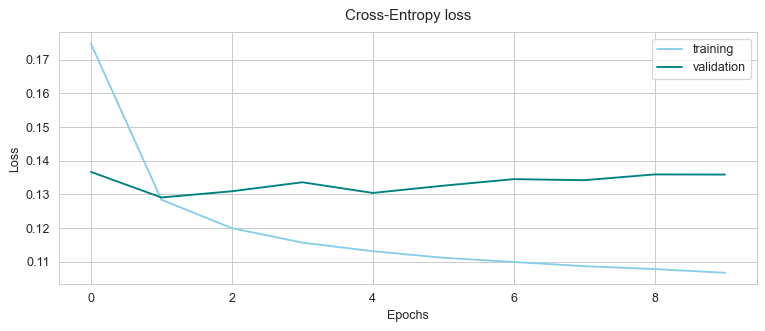

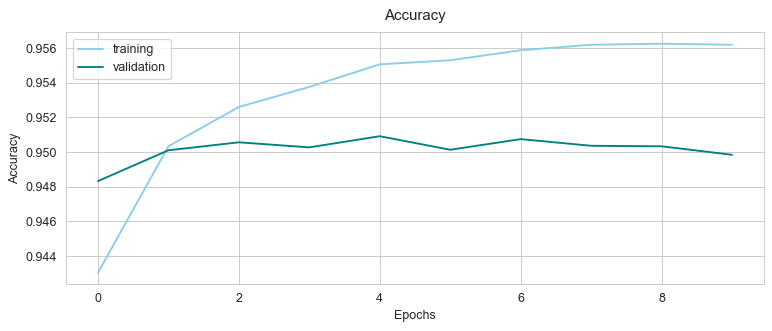

In [26]:
plt.figure(figsize = (10, 8), dpi = 90)
plt.subplot(211)
plt.title("Cross-Entropy loss", pad=10)
plt.plot(history.history['loss'], label='training', color='skyblue')
plt.plot(history.history['val_loss'], label='validation', color='teal')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()


# plot accuracy learning curves
plt.figure(figsize = (10, 8), dpi = 90)
plt.subplot(212)
plt.title('Accuracy', pad=10)
plt.plot(history.history['accuracy'], label='training', color='skyblue')
plt.plot(history.history['val_accuracy'], label='validation', color='teal')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [30]:
val_paded[20]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    3,   13,    2, 1487,  159,   14,  842,  218])

In [38]:
train_inp[:5]

['do iit professors use quora',
 'what are emarketing strategies',
 'if liberals genuinely dislike hierarchies and believe in egalitarianism why do they support compulsory schooling and believe in the inferiority of teenagers',
 'do you desire to be great or to do something great',
 'what is fieldturf made of']

In [39]:
train_target[:5]

array([0, 0, 1, 0, 0], dtype=int64)

## Make predictions below

In [ ]:
# on going..